In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy
import seaborn as sns
sns.set_theme(palette='deep')

from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.config import DEVICE

In [2]:
import ray
ray.init()

2023-05-17 10:54:15,444	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.0
Ray version:,2.0.1


# Evaluation - Heston

In [3]:
trading_freq: int = 5
uncertainty_aversion: float = 130
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)
hedge_objective = Entropy(uncertainty_aversion)

In [4]:
estimated_heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=2,
    vol_of_vol=0.2,
    correlation=0.8,
)

In [5]:
estimated_generator = HestonGenerator(estimated_heston_parameters).provide_generator(
    initial_value=np.array([1.0, estimated_heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
reference_paths = estimated_generator(2**16)

pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizer = SigWassersteinMetric(reference_paths[:, :, 0:2], pen_config, transform=lambda x: 10000 * x)

## Test Data

In [6]:
pars_f = 'resources/uncertainty-test-sets/heston/next_parameters_clean.npy'
pars_coarseness = 0
pars = np.load(pars_f, allow_pickle=True)
par_sets = [HestonParameterSet(
    drift=0.0,
    reversion_level=d[0],
    reversion_speed=d[1],
    vol_of_vol=d[2],
    correlation=d[3],
) for d in pars]

In [7]:
parameter_names = ['Reversion Speed', 'Reverison Level', 'Vol of Vol', 'Correlation']

In [8]:
pars_by_coarseness = {c: np.load(f'resources/uncertainty-test-sets/heston/{c}.npy', allow_pickle=True) for c in ('pars_1_20_50350_corrected_ex', 'pars_1_10_36957_corrected_ex', 'pars_1_100_38459_corrected')}

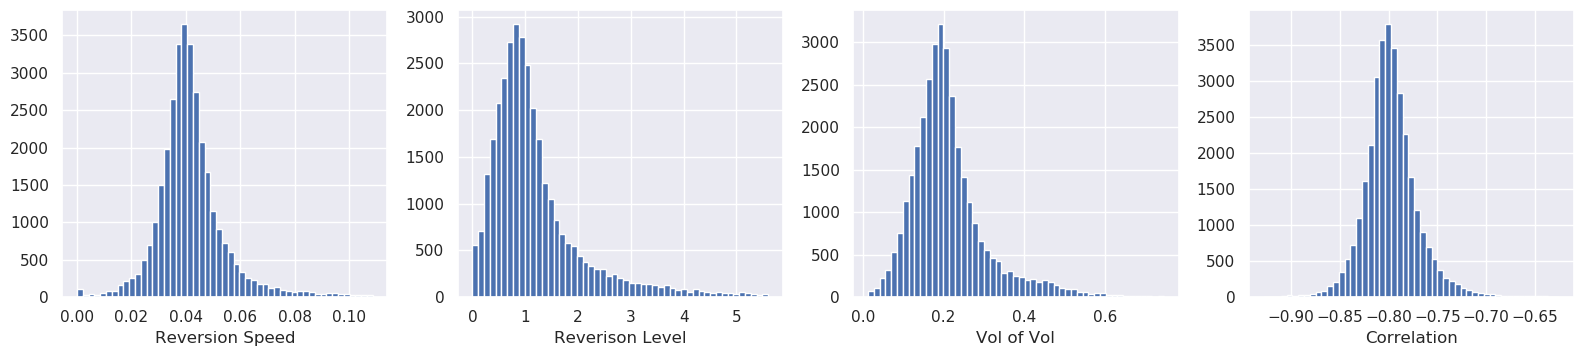

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for k, ax in zip(range(4), axs):
    ax.hist([d[k] for d in pars][:2**15], bins=51, alpha=1.)
    # ax.axvline(estimated_heston_parameters.__dict__[k if k[0] != '_' else k[1:]], c='black', ls='--', label='Estimated')
    ax.set_xlabel(parameter_names[k])
    if k == 'reversion_speed':
        ax.set_ylabel('Frequency')
    # ax.legend()
# ax.set_yscale('log')
# st = fig.suptitle('Scenarios for Various Data-Densities')
# st.set_y(1.0)
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('figs/HestonUncertaintyData.pdf')
plt.show()

### Test Generators

In [10]:
test_generators = [
    HestonGenerator(parameter=ps).provide_generator(
        initial_value=np.array([1.0, ps.reversion_level]),
        times=td.times,
        random_number_generator=np.random.default_rng(2222 + i),
        device='cpu',
    ) for i, ps in enumerate(par_sets)
]

In [11]:
@ray.remote
def generate(index, gen, number_of_paths):
    return index, gen(number_of_paths)

## Loading Deep Hedges and Robust Hedge GANs

In [12]:
target_folder = f'resources/network-states/test_h_alt/ua{uncertainty_aversion:03}/tf_{trading_freq:02}'
target_folder

'resources/network-states/test_h_alt/ua130/tf_05'

### Deep and Optimal Hedges

In [13]:
deep_hedge = DeepHedgeHeston(
    DeepHedgeHestonConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([
                1.0,
                estimated_heston_parameters.reversion_level,
                HestonGenerator(parameter=estimated_heston_parameters).get_correction_term(td.maturity, estimated_heston_parameters.reversion_level),
            ], dtype=torch.float32, device=DEVICE),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=2,
            dim_of_tradable_asset=2,
            number_of_layers=2,
            nodes_in_intermediate_layers=128,
        ),
    )
)
optimal_hedge = deepcopy(deep_hedge)

In [14]:
deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge_post_trained.pt'))

<All keys matched successfully>

In [15]:
optimal_hedge.load_state_dict(torch.load(f'{target_folder}/optimal_hedge_pc{0}.pt'))

<All keys matched successfully>

### Robust Hedge GANs

In [16]:
penalty_scales = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000]
[p/42 for p in penalty_scales]

[59.523809523809526,
 119.04761904761905,
 178.57142857142858,
 238.0952380952381,
 297.6190476190476,
 357.14285714285717,
 416.6666666666667,
 476.1904761904762,
 595.2380952380952]

In [17]:
rh_gans = {pen_s: deepcopy(deep_hedge) for pen_s in penalty_scales}

In [18]:
for pen_s in penalty_scales:
    rh_gans[pen_s].load_state_dict(torch.load(f'{target_folder}/v_sigw_{pen_s:05.0f}/rhgan_dh.pt'))

## Evaluating OOSP

In [19]:
no_to_display = 10000

In [20]:
dh_oosp_by_par = {}
oh_oosp_by_par = {}
rhgan_oosp_by_pen_by_par = {pen: {} for pen in penalty_scales}
distances_to_estimate_dict = {}
for indices in tqdm(np.array_split(np.arange(no_to_display), np.arange(48,no_to_display,48))):
    for i, paths in ray.get([generate.remote(index=i, gen=test_generators[i], number_of_paths=no_to_display) for i in indices]):
        paths = paths.cuda()
        increments = torch.diff(paths, 1, 1)
        dh_oosp_by_par[i] = hedge_objective(deep_hedge(increments)).cpu().item()
        oh_oosp_by_par[i] = hedge_objective(optimal_hedge(increments)).cpu().item()
        for pen in penalty_scales:
            rhgan_oosp_by_pen_by_par[pen][i] = hedge_objective(rh_gans[pen](increments)).cpu().item() 
        distances_to_estimate_dict[i] = penalizer(paths[:, :, 0:2]).item()

In [21]:
dh_oosps = [dh_oosp_by_par[i] for i in range(no_to_display)]
oh_oosps = [oh_oosp_by_par[i] for i in range(no_to_display)]
rhgan_oosps_by_pen = {pen: [rhgan_oosp_by_pen_by_par[pen][i] for i in range(no_to_display)] for pen in penalty_scales}
distances_to_estimate = [distances_to_estimate_dict[i] for i in range(no_to_display)]

In [22]:
print(f'                   Mean:       Std:')
print(f'Deep Hedge:        {np.mean(dh_oosps):.6f}    {np.std(dh_oosps):.6f}')
print(f'Opt. Hedge:        {np.mean(oh_oosps):.6f}    {np.std(oh_oosps):.6f}')
for pen in penalty_scales:
    print(f'Robust Hedge GAN:  {np.mean(rhgan_oosps_by_pen[pen]):.6f}    {np.std(rhgan_oosps_by_pen[pen]):.6f}')

                   Mean:       Std:
Deep Hedge:        0.055450    0.011061
Opt. Hedge:        0.056183    0.008704
Robust Hedge GAN:  0.058885    0.008593
Robust Hedge GAN:  0.055720    0.008648
Robust Hedge GAN:  0.055323    0.009087
Robust Hedge GAN:  0.055194    0.009385
Robust Hedge GAN:  0.055119    0.009713
Robust Hedge GAN:  0.055372    0.009408
Robust Hedge GAN:  0.055017    0.009807
Robust Hedge GAN:  0.054932    0.009492
Robust Hedge GAN:  0.055441    0.009918


In [23]:
sns.color_palette("husl", 8)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

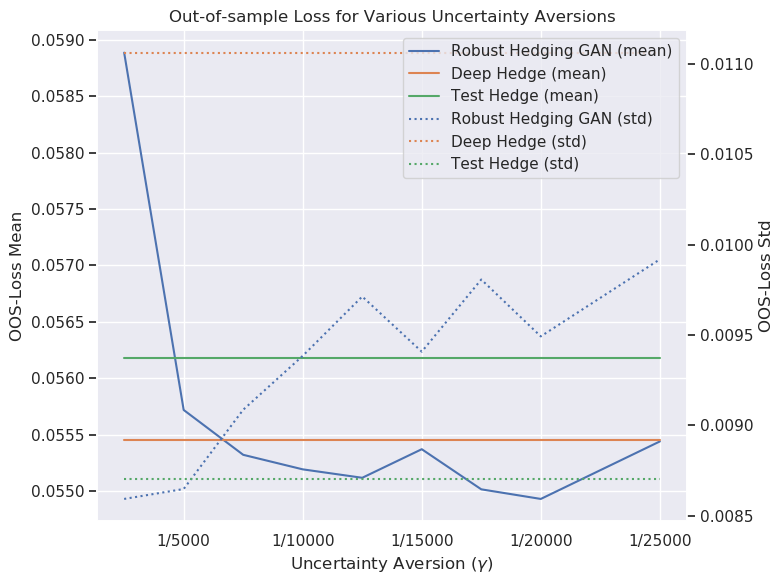

In [70]:
fig, axl = plt.subplots(figsize=(8,6))
axl.plot(penalty_scales, [np.mean(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], label='Robust Hedging GAN (mean)')
axl.plot(penalty_scales, [np.mean(dh_oosps) for pen in penalty_scales], c='C1', label='Deep Hedge (mean)')
axl.plot(penalty_scales, [np.mean(oh_oosps) for pen in penalty_scales], c='C2', label='Test Hedge (mean)')
axl.set_title('Out-of-sample Loss for Various Uncertainty Aversions')
axl.set_xlabel(r'Uncertainty Aversion ($\gamma$)')
axl.set_ylabel('OOS-Loss Mean')

axr = axl.twinx()
axr.plot(penalty_scales, [np.std(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], ls=':', label='Robust Hedging GAN (std)')
axr.plot(penalty_scales, [np.std(dh_oosps) for pen in penalty_scales], c='C1', ls=':', label='Deep Hedge (std)')
axr.plot(penalty_scales, [np.std(oh_oosps) for pen in penalty_scales], c='C2', ls=':', label='Test Hedge (std)')
axr.set_ylabel('OOS-Loss Std')
axr.grid(False)

# axl.set_xticklabels([(f'{1/float(i.get_text()):0.2f}' if i.get_text() != '0' else np.inf) for i in ax.get_xticklabels()])

lines, labels = axl.get_legend_handles_labels()
lines2, labels2 = axr.get_legend_handles_labels()
axr.legend(lines + lines2, labels + labels2, loc=1)
plt.tight_layout()

plt.draw()
axl.set_xticklabels([(f'1/' + i.get_text() if float(i.get_text()) != 0 else '') for i in axl.get_xticklabels()])
plt.savefig('figs/HestonOOSPComparisonHistorical.pdf')
plt.show()